<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/01_gcolab/03_thesis_extract_additional_features_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_numeric(df, feature, label_col="label"):
    weights = df.groupby(label_col)[feature].transform(lambda x: 1 / len(x))

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=feature,
        hue=label_col,
        bins=50,
        weights=weights,
        alpha=0.6
    )
    plt.title(f"{feature} by {label_col} (normalized)")
    plt.ylabel("Relative frequency")
    plt.show()


def plot_boolean(df, feature, label_col="label"):
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col
    )
    plt.title(f"{feature} by {label_col}")
    plt.ylabel("Proportion")
    plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def cosine_sim(a, b):
    if not isinstance(a, np.ndarray) or not isinstance(b, np.ndarray):
        return np.nan
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0]

def add_tweet_temporal_and_semantic_features(df):
    df = df.copy()

    # --- Temporal features ---
    df["tweet_hour"] = df["created_at"].dt.hour
    df["tweet_day_of_week"] = df["created_at"].dt.dayofweek
    df["tweet_is_weekend"] = df["tweet_day_of_week"].isin([5, 6]).astype(int)

    # Cyclical encoding
    df["tweet_hour_sin"] = np.sin(2 * np.pi * df["tweet_hour"] / 24)
    df["tweet_hour_cos"] = np.cos(2 * np.pi * df["tweet_hour"] / 24)

    df["tweet_dow_sin"] = np.sin(2 * np.pi * df["tweet_day_of_week"] / 7)
    df["tweet_dow_cos"] = np.cos(2 * np.pi * df["tweet_day_of_week"] / 7)

    # --- Sort for sequential features ---
    df = df.sort_values(["author_id", "created_at"])

    # --- Inter-tweet timing ---
    df["tweet_time_delta_sec"] = (
        df.groupby("author_id")["created_at"]
        .diff()
        .dt.total_seconds()
    )

    # --- Previous embedding ---
    df["prev_embedding"] = (
        df.groupby("author_id")["embedding"]
        .shift(1)
    )

    df["tweet_cosine_sim_prev"] = df.apply(
        lambda row: cosine_sim(row["embedding"], row["prev_embedding"]),
        axis=1
    )

    # --- User centroid ---
    user_centroids = (
        df.groupby("author_id")["embedding"]
        .apply(lambda x: np.mean(np.vstack(x), axis=0))
    )

    df = df.join(
        user_centroids.rename("user_embedding_centroid"),
        on="author_id"
    )

    # --- Similarity to centroid ---
    df["tweet_cosine_sim_centroid"] = df.apply(
        lambda row: cosine_sim(
            row["embedding"], row["user_embedding_centroid"]
        ),
        axis=1
    )

    return df

In [ ]:
import joblib

path = "/content/drive/MyDrive/twibot-22/processed"

user_features = joblib.load(f"{path}/user_features_1.joblib")

In [ ]:
edges = pd.read_parquet(f"{path}/edges_filtered.parquet", engine='pyarrow')
edges.head(2)

,target_id,source_id,relation
0,u1000115670657318912,u894057794,followers
1,u1000115670657318912,u55857505,following


In [ ]:
edges["relation"].unique()

array(['followers', 'following'], dtype=object)

In [ ]:
edges_1 = (
    edges
    .loc[edges["relation"] == "following",
         ["source_id", "target_id"]]
    .reset_index(drop=True)
)

In [ ]:
edges_1.head()

,source_id,target_id
0,u55857505,u1000115670657318912
1,u398087684,u1000115670657318912
2,u147491637,u1000115670657318912
3,u246939962,u1000115670657318912
4,u421795636,u1000115670657318912


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edges_1.values)

In [ ]:
def extract_node_features(G):
  return pd.DataFrame({
      "out_degree": dict(G.out_degree()),
      "in_degree": dict(G.in_degree()),
      "pagerank": nx.pagerank(G),
      "clustering": nx.clustering(G.to_undirected()),
      "n_neighbors": dict(nx.degree(G.to_undirected()))
      })

In [ ]:
user_network_features = extract_node_features(G)
user_network_features.head()

,out_degree,in_degree,pagerank,clustering,n_neighbors
u55857505,210,2,0.000026,0.007583,211
u1000115670657318912,0,7,0.000025,0.238095,7
u398087684,192,14,0.000029,0.008383,206
u147491637,151,2,0.000024,0.020309,151
u246939962,179,58,0.000037,0.026343,233


In [ ]:
user_network_features[f"out_in_ratio"] = (
    user_network_features[f"out_degree"] /
     (user_network_features[f"in_degree"] + 1)
)

In [ ]:
user_features = user_features.merge(
    user_network_features,
    left_on="id",
    right_index=True,
    how="left"
)
user_features.head(1)

,id,name_length,username_length,username_name_length_ratio,description,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,created_at,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,desc_is_retweet,desc_is_quote,description_normalized,desc_embedding,out_degree,in_degree,pagerank,clustering,n_neighbors,out_in_ratio
0,u1000115670657318912,4,6,1.5,"Open source tool for data & models versioning for ML projects. Join our stellar community https://t.co/vBp8rcV4bf for help, support and insights.",True,True,False,True,True,False,0.0,0.0,0.25,0.0,3.0,1.0,2.0,2.584963,0.666667,False,False,2018-05-25 20:45:31+00:00,241981329,3488,325,79,911,10.732308,21.464615,0.093177,0.000027,0.085235,0.022649,0.261181,0.086718,0.000014,0.000001,3.264715e-07,0.000004,0,True,127.0,20.0,2.0,10.0,5.05,2.312466,0.9,4.024922,0.1,0.85,0.0,0.069307,0.930693,0.047244,0.047244,0.15748,0.0,0.0,0.0,False,1.0,True,0.0,0.0,0.0,False,False,0.765,0.765,0.235,0.375,57.095,7.78,1.65,0.1,4.407766,4.084184,1.111111,0.889764,False,False,False,False,False,True,False,0.2,0.5,0.1,0.05,0.15,False,None,None,"Open source tool for data & models versioning for ML projects . Join our stellar community HTTPURL for help , support and insights .","[-0.012774717, 0.18525192, 0.16701874, -0.10268895, 0.10385812, -0.10335298, 0.13834423, -0.20053321, 0.03584733, -0.18977706, -0.02330352, 0.1209626, 0.07864394, 0.16501889, -0.03266774, -0.3008522, 0.041388795, 0.06296115, 0.42929772, 0.27648813, 0.029083474, -0.7367115, -0.0793228, -0.11158177, 0.11357711, -0.09452795, 0.029607087, -0.1097236, -0.20597014, 0.036942385, 0.1547957, 0.2840446, -0.5154487, -0.222085, 0.24380401, 0.020896174, -0.10492506, 0.17496282, 0.17498569, 0.13593167, 0.11925094, -0.098888, 0.23857471, -0.2900297, 0.22335666, -0.12353653, 0.22888961, -0.12354477, 0.22138578, 0.061687242, 0.21896324, 0.26271552, 0.2834182, 0.2031318, -0.07017809, -0.6635443, -0.03332421, 0.41275877, 0.3837363, 0.21015719, -0.0593528, -0.14655046, 0.41895065, 0.31466633, 0.62861925, 0.08625303, 0.041362144, -0.14618306, -0.0941003, 0.25382102, -0.21858457, -0.5171837, 0.106715634, 0.12347865, -0.55522764, -0.160474, -0.07300675, 0.15814953, -0.2535827, -0.12769426, -0.1725724, -0.09640145, 0.0016981688, 0.3103977, -0.022450611, -0.15526228, 0.13197842, 0.17046584, 0.185

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


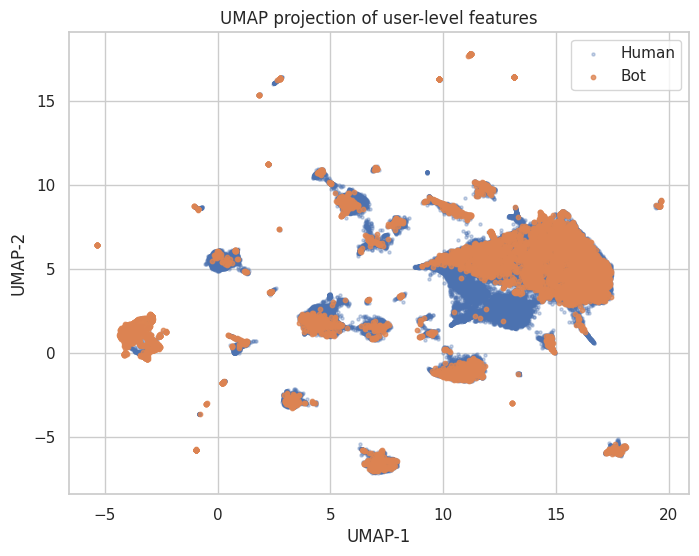

In [ ]:
user_features.columns.tolist()

exclude_cols = ["id", "label", "description", "description_normalized", "desc_embedding"]

X = user_features.drop(columns=exclude_cols)

# select bool + numeric
X = X.select_dtypes(include=[bool, np.number])
y = user_features["label"]

X = (
    X.replace([np.inf, -np.inf], np.nan)
     .fillna(0)
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# humans first
mask_human = y == 0
plt.scatter(
    X_umap[mask_human, 0],
    X_umap[mask_human, 1],
    s=5,
    alpha=0.3,
    label="Human"
)

# bots on top
mask_bot = y == 1
plt.scatter(
    X_umap[mask_bot, 0],
    X_umap[mask_bot, 1],
    s=10,
    alpha=0.8,
    label="Bot"
)

plt.legend()
plt.title("UMAP projection of user-level features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [ ]:
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                               Missing Count  Missing Percentage
quote_count                           796093           75.899847
reply_count                           796093           75.899847
tweet_avg_word_length                     25            0.002384
tweet_std_word_length                     25            0.002384
tweet_unique_word_ratio                   25            0.002384
tweet_guiraud_index                       25            0.002384
tweet_repetition_ratio                    25            0.002384
tweet_hapax_ratio                         25            0.002384
tweet_uppercase_ratio                      2            0.000191
tweet_lowercase_ratio                      2            0.000191
tweet_polysyllabic_word_ratio             25            0.002384
tweet_word_entropy                        25            0.002384
tweet_avg_word_repetition                 25            0.002384
tweet_function_word_ratio

In [ ]:
tweet_features['quote_count_missing'] = tweet_features['quote_count'].isnull().astype(bool)
tweet_features['reply_count_missing'] = tweet_features['reply_count'].isnull().astype(bool)

zero_fill = [
    "quote_count",
    "reply_count",
    "tweet_unique_word_ratio",
    "tweet_repetition_ratio",
    "tweet_hapax_ratio",
    "tweet_uppercase_ratio",
    "tweet_lowercase_ratio",
    "tweet_polysyllabic_word_ratio",
    "tweet_word_entropy",
    "tweet_function_word_ratio",
    "tweet_noun_ratio",
    "tweet_verb_ratio",
    "tweet_pronoun_ratio",
    "tweet_adjective_ratio"
]

median_fill = [
    "tweet_avg_word_length",
    "tweet_std_word_length",
    "tweet_guiraud_index",
    "tweet_avg_word_repetition"
]

tweet_features[zero_fill] = tweet_features[zero_fill].fillna(0)
tweet_features[median_fill] = tweet_features[median_fill].apply(
    lambda x: x.fillna(x.median())
)

In [ ]:
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [ ]:
for col in tweet_features.columns:
    print(f"{col}: {tweet_features[col].dtype}")

author_id: object
id: object
text: object
created_at: object
is_reply: int32
is_sensitive: int32
like_count: int64
quote_count: float64
reply_count: float64
retweet_count: int64
label: int64
tweet_is_present: bool
tweet_length: int64
tweet_num_words: int64
tweet_num_sentences: int64
tweet_avg_sentence_length: float64
tweet_avg_word_length: float64
tweet_std_word_length: float64
tweet_unique_word_ratio: float64
tweet_guiraud_index: float64
tweet_repetition_ratio: float64
tweet_hapax_ratio: float64
tweet_digit_ratio: float64
tweet_uppercase_ratio: float64
tweet_lowercase_ratio: float64
tweet_special_char_ratio: float64
tweet_punctuation_ratio: float64
tweet_whitespace_ratio: float64
tweet_emoji_count: int64
tweet_emoji_ratio: float64
tweet_mention_count: int64
tweet_contains_mention: bool
tweet_url_count: int64
tweet_contains_url: bool
tweet_hashtag_count: int64
tweet_cashtag_count: int64
tweet_email_count: int64
tweet_contains_bot_word_or_hashtag: bool
tweet_contains_ai_hashtag: bool
tw

In [ ]:
bool_cols = ["is_reply", "is_sensitive"]
int_cols = ["quote_count", "reply_count"]

tweet_features[bool_cols] = tweet_features[bool_cols].astype("bool")
tweet_features[int_cols] = tweet_features[int_cols].astype("int64")

In [ ]:
exclude_cols = {
    "author_id",
    "id",
    "text",
    "created_at",
    "label"
}

feature_cols = [
    c for c in tweet_features.columns
    if c not in exclude_cols
]

bool_cols = tweet_features[feature_cols].select_dtypes(include=[bool]).columns.tolist()
numeric_cols = tweet_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

In [ ]:
agg_dict = {}

for c in bool_cols:
    agg_dict[c] = "mean"

for c in numeric_cols:
    agg_dict[c] = ["mean", "std"]

In [ ]:
user_features_from_tweets = (
    tweet_features
    .groupby("author_id")
    .agg(agg_dict)
)

In [ ]:
user_features_from_tweets.columns = [
    f"{col}_{stat}" if isinstance(stat, str) else col
    for col, stat in user_features_from_tweets.columns
]
user_features_from_tweets.reset_index(inplace=True)
user_features_from_tweets.head()

,author_id,is_reply_mean,is_sensitive_mean,tweet_is_present_mean,tweet_contains_mention_mean,tweet_contains_url_mean,tweet_contains_bot_word_or_hashtag_mean,tweet_contains_ai_hashtag_mean,tweet_starts_with_emoji_mean,tweet_ends_with_emoji_mean,tweet_starts_with_url_mean,tweet_ends_with_url_mean,tweet_contains_pipe_or_bullet_mean,tweet_contains_call_to_action_mean,tweet_contains_ai_phrase_mean,tweet_contains_repeated_chars_mean,tweet_is_retweet_mean,tweet_is_quote_mean,quote_count_missing_mean,reply_count_missing_mean,like_count_mean,like_count_std,quote_count_mean,quote_count_std,reply_count_mean,reply_count_std,retweet_count_mean,retweet_count_std,tweet_length_mean,tweet_length_std,tweet_num_words_mean,tweet_num_words_std,tweet_num_sentences_mean,tweet_num_sentences_std,tweet_avg_sentence_length_mean,tweet_avg_sentence_length_std,tweet_avg_word_length_mean,tweet_avg_word_length_std,tweet_std_word_length_mean,tweet_std_word_length_std,tweet_unique_word_ratio_mean,tweet_unique_word_ratio_std,tweet_guiraud_index_mean,tweet_guiraud_index_std,tweet_repetition_ratio_mean,tweet_repetition_ratio_std,tweet_hapax_ratio_mean,tweet_hapax_ratio_std,tweet_digit_ratio_mean,tweet_digit_ratio_std,tweet_uppercase_ratio_mean,tweet_uppercase_ratio_std,tweet_lowercase_ratio_mean,tweet_lowercase_ratio_std,tweet_special_char_ratio_mean,tweet_special_char_ratio_std,tweet_punctuation_ratio_mean,tweet_punctuation_ratio_std,tweet_whitespace_ratio_mean,tweet_whitespace_ratio_std,tweet_emoji_count_mean,tweet_emoji_count_std,tweet_emoji_ratio_mean,tweet_emoji_ratio_std,tweet_mention_count_mean,tweet_mention_count_std,tweet_url_count_mean,tweet_url_count_std,tweet_hashtag_count_mean,tweet_hashtag_count_std,tweet_cashtag_count_mean,tweet_cashtag_count_std,tweet_email_count_mean,tweet_email_count_std,tweet_sentiment_mean,tweet_sentiment_std,tweet_sentiment_abs_mean,tweet_sentiment_abs_std,tweet_sentiment_neutrality_mean,tweet_sentiment_neutrality_std,tweet_sentiment_subjectivity_mean,tweet_sentiment_subjectivity_std,tweet_flesch_reading_ease_mean,tweet_flesch_reading_ease_std,tweet_flesch_kincaid_grade_mean,tweet_flesch_kincaid_grade_std,tweet_avg_syllables_per_word_mean,tweet_avg_syllables_per_word_std,tweet_polysyllabic_word_ratio_mean,tweet_polysyllabic_word_ratio_std,tweet_char_entropy_mean,tweet_char_entropy_std,tweet_word_entropy_mean,tweet_word_entropy_std,tweet_avg_word_repetition_mean,tweet_avg_word_repetition_std,tweet_compression_ratio_mean,tweet_compression_ratio_std,tweet_function_word_ratio_mean,tweet_function_word_ratio_std,tweet_noun_ratio_mean,tweet_noun_ratio_std,tweet_verb_ratio_mean,tweet_verb_ratio_std,tweet_pronoun_ratio_mean,tweet_pronoun_ratio_std,tweet_adjective_ratio_mean,tweet_adjective_ratio_std
0,u1000016040288555009,0.00,0.0,1.0,1.00,0.25,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.25,0.0,0.25,1.00,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,1.00,0.000000,133.25,8.845903,19.00,2.160247,2.00,0.816497,11.125000,6.005206,4.839035,0.909734,2.312111,1.070755,0.987500,0.025000,4.297501,0.242172,0.012500,0.025000,0.975000,0.050000,0.041293,0.009071,0.113984,0.026531,0.886016,0.026531,0.110613,0.045812,0.076361,0.029509,0.148557,0.012375,1.50,1.290994,0.011413,0.009693,1.00,0.000000,0.25,0.500000,1.25,1.258306,0.25,0.500000,0.0,0.0,0.272625,0.562220,0.465575,0.355214,0.534425,0.355214,0.293750,0.196659,62.736845,18.884894,7.831520,3.069916,1.542819,0.230711,0.100063,0.099979,4.753024,0.065509,4.215543,0.162067,1.013158,0.026316,1.023679,0.065583,0.183968,0.018181,0.409156,0.108177,0.169619,0.087152,0.038221,0.050016,0.108882,0.086652
1,u1000028117430304769,0.00,0.0,1.0,1.00,0.50,0.0,0.0,0.0,0.00,0.0,0.50,0.0,1.00,0.0,0.00,1.00,0.0,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,8152.50,5193.699308,88.50,44.547727,12.50,9.192388,2.00,1.414214,6.166667,0.235702,4.429825,1.277754,1.869666,0.787770,0.921053,0.111648,3.060071,0.863492,0.078947,0.111648,0.842105,0.223297,0.038816,0.019538,0.671053,0.465202,0.328947,0.465202,0.175658,0.024501,0.098904,0.033805,0.

In [ ]:
user_features_1 = user_features.merge(
    user_features_from_tweets,
    left_on="id",
    right_on="author_id",
    how="left"
)
#user_features_1.head(1)

In [ ]:
tweet_features["created_at"] = pd.to_datetime(
    tweet_features["created_at"],
    errors="coerce",
    utc=True
)

#tweet_features_1 = add_tweet_temporal_and_semantic_features(tweet_features)
#tweet_features_1.head(1)

In [ ]:
import numpy as np

def entropy(x):
    counts = x.value_counts(normalize=True)
    return -(counts * np.log(counts)).sum()

def pct_within_threshold(x, threshold):
    x = x.dropna()
    if len(x) == 0:
        return 0.0
    return (x <= threshold).mean()

from sklearn.linear_model import LinearRegression
import numpy as np

def sentiment_slope(group):
    if len(group) < 2:
        return np.nan

    t = (
        group["created_at"] - group["created_at"].min()
    ).dt.total_seconds().values.reshape(-1, 1)

    y = group["tweet_sentiment"].values

    model = LinearRegression()
    model.fit(t, y)
    return model.coef_[0]

In [ ]:
test = test.sort_values(["author_id", "created_at"])

user_temporal_features = (
    test
    .groupby("author_id")
    .agg(
        weekend_post_ratio=("tweet_is_weekend", "mean"),
        mean_posting_hour=("tweet_hour", "mean"),
        posting_hour_std=("tweet_hour", "std"),
        posting_hour_entropy=("tweet_hour", entropy),
        posting_dow_entropy=("tweet_day_of_week", entropy),
    )
    .fillna(0)
)

user_delta_stats = (
    test
    .groupby("author_id")["tweet_time_delta_sec"]
    .agg(
        delta_mean="mean",
        delta_median="median",
        delta_std="std",
        delta_min="min",
    )
)

user_delta_stats["delta_burstiness"] = (
    user_delta_stats["delta_std"] / user_delta_stats["delta_mean"]
)

user_fast_posting = (
    test
    .groupby("author_id")["tweet_time_delta_sec"]
    .agg(
        pct_within_10s=lambda x: pct_within_threshold(x, 10),
        pct_within_60s=lambda x: pct_within_threshold(x, 60),
        pct_within_5min=lambda x: pct_within_threshold(x, 300),
    )
)

user_intertweet_features = (
    pd.concat([user_delta_stats, user_fast_posting], axis=1)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

user_semantic_features = (
    test
    .groupby("author_id")["tweet_cosine_sim_centroid"]
    .agg(
        sem_centroid_sim_mean="mean",
        sem_centroid_sim_max="max",
        sem_centroid_sim_std="std",
    )
    .fillna(0)
)

user_embedding_std_mean = (
    test
    .groupby("author_id")["text_embedding"]
    .apply(lambda x: np.std(np.vstack(x), axis=0).mean())
    .rename("embedding_std_mean")
)

user_embedding_features = user_embedding_std_mean.to_frame()

user_activity = (
    test
    .groupby("author_id")
    .agg(
        retweet_to_tweet_ratio=("tweet_is_retweet", "mean"),
        reply_to_tweet_ratio=("is_reply", "mean"),
        quote_to_tweet_ratio=("tweet_is_quote", "mean"),
    )
    .fillna(0)
)

user_readability_std = (
    test
    .groupby("author_id")["tweet_flesch_reading_ease"]
    .std()
    .rename("readability_std_over_time")
    .fillna(0)
)

user_sentiment_slope = (
    test
    .groupby("author_id")
    .apply(sentiment_slope)
    .rename("sentiment_time_slope")
    .fillna(0)
)

user_style_features = pd.concat(
    [user_readability_std, user_sentiment_slope],
    axis=1
)

tweet_rate = (
    test
    .groupby("author_id")
    .size()
    .rename("n_tweets")
)

account_span_days = (
    test
    .groupby("author_id")["created_at"]
    .agg(lambda x: (x.max() - x.min()).days + 1)
    .rename("active_days")
)

user_tweet_rate = (tweet_rate / account_span_days).rename("tweet_rate")

user_last_tweet_date = (
    test
    .groupby("author_id")["created_at"]
    .max()
)

#user_features["account_age_days"] = (
#    user_last_tweet_date - user_features["account_created_at"]
#).dt.days

#user_features["tweet_rate_x_account_age"] = (
#    user_tweet_rate * user_features["account_age_days"]
#)

user_hashtag_ratio = (
    test
    .groupby("author_id")["tweet_hashtag_count"]
    .mean()
    .rename("avg_hashtag_count")
)

user_features["followers_x_hashtag_ratio"] = (
    user_features["followers_count"] * user_hashtag_ratio
)

user_emoji_ratio = (
    test
    .groupby("author_id")["tweet_emoji_ratio"]
    .mean()
    .rename("avg_emoji_ratio")
)

user_features["verified_x_emoji"] = (
    user_features["is_verified"] * user_emoji_ratio
)

user_features = user_features.join(
    [
        user_temporal_features,
        user_intertweet_features,
        user_semantic_features,
        user_embedding_features,
        user_activity,
        user_style_features,
        user_tweet_rate,
    ],
    how="left"
)

user_features = user_features.fillna(0)

In [ ]:
import joblib

joblib.dump(tweet_features, f"../../02_data/tweet_features_2.joblib")

In [ ]:
user_features_test = user_features.drop(columns="desc_embedding")

In [ ]:
user_features_test.head(1)

,id,name_length,username_length,username_name_length_ratio,description,has_name,has_username,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,ratio_digits_in_name,ratio_digits_in_username,ratio_special_chars_in_name,ratio_special_chars_in_username,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,is_protected,is_verified,created_at,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,desc_is_present,desc_length,desc_num_words,desc_num_sentences,desc_avg_sentence_length,desc_avg_word_length,desc_std_word_length,desc_unique_word_ratio,desc_guiraud_index,desc_repetition_ratio,desc_hapax_ratio,desc_digit_ratio,desc_uppercase_ratio,desc_lowercase_ratio,desc_special_char_ratio,desc_punctuation_ratio,desc_whitespace_ratio,desc_emoji_count,desc_emoji_ratio,desc_mention_count,desc_contains_mention,desc_url_count,desc_contains_url,desc_hashtag_count,desc_cashtag_count,desc_email_count,desc_contains_bot_word_or_hashtag,desc_contains_ai_hashtag,desc_sentiment,desc_sentiment_abs,desc_sentiment_neutrality,desc_sentiment_subjectivity,desc_flesch_reading_ease,desc_flesch_kincaid_grade,desc_avg_syllables_per_word,desc_polysyllabic_word_ratio,desc_char_entropy,desc_word_entropy,desc_avg_word_repetition,desc_compression_ratio,desc_starts_with_emoji,desc_ends_with_emoji,desc_starts_with_url,desc_ends_with_url,desc_contains_pipe_or_bullet,desc_contains_call_to_action,desc_contains_ai_phrase,desc_function_word_ratio,desc_noun_ratio,desc_verb_ratio,desc_pronoun_ratio,desc_adjective_ratio,desc_contains_repeated_chars,desc_is_retweet,desc_is_quote,description_normalized
0,u1000115670657318912,4,6,1.5,"Open source tool for data & models versioning for ML projects. Join our stellar community https://t.co/vBp8rcV4bf for help, support and insights.",True,True,False,True,True,False,0.0,0.0,0.25,0.0,3.0,1.0,2.0,2.584963,0.666667,False,False,2018-05-25 20:45:31+00:00,241981329,3488,325,79,911,10.732308,21.464615,0.093177,0.000027,0.085235,0.022649,0.261181,0.086718,0.000014,0.000001,3.264715e-07,0.000004,0,True,127.0,20.0,2.0,10.0,5.05,2.312466,0.9,4.024922,0.1,0.85,0.0,0.069307,0.930693,0.047244,0.047244,0.15748,0.0,0.0,0.0,False,1.0,True,0.0,0.0,0.0,False,False,0.765,0.765,0.235,0.375,57.095,7.78,1.65,0.1,4.407766,4.084184,1.111111,0.889764,False,False,False,False,False,True,False,0.2,0.5,0.1,0.05,0.15,False,None,None,"Open source tool for data & models versioning for ML projects . Join our stellar community HTTPURL for help , support and insights ."


In [ ]:
import pandas as pd

edges = pd.read_csv("../../02_data/edge.csv")

In [ ]:
edges.head(1)

,source_id,relation,target_id
0,u980749991491682304,followers,u1480979504696864775


In [ ]:
edges["relation"].unique()

array(['followers', 'following', 'own', 'pinned', 'post', 'contain',
       'discuss', 'mentioned', 'like', 'followed', 'replied_to',
       'retweeted', 'quoted', 'membership'], dtype=object)

In [ ]:
edges_1 = edges[edges["source_id"].isin(user_features["id"].unique())]
edges_1 = edges_1[edges_1["target_id"].isin(user_features["id"].unique())]
edges_1.shape